**IMPORTING THE LIBRARIES AND THE DATAFILE**

In [1510]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [1511]:
dump=pd.read_csv("dump.csv")

*Going through the sample of data*

In [1512]:
dump.head(3)

,Unnamed: 0,Id,TransactionDate,DueDate,DateFullyPaid,SellerId,BuyerId,Amount,Balance,Deposit,...,SalesTerm,Estimate,sel_id,sel_orgtype,sel_Business_type,sel_fiscal_year_start_month,buy_id,buy_first_engaged,buy_most_recent_engaged,buy_prev_engaged
0,0,90802,2017-06-30T00:00:00.000Z,2017-06-30T00:00:00.000Z,NaN,13,16140,74970.0,0.0,0.0,...,NaN,NaN,13,SCorporation,NaN,January,16140,2015-12-31T00:00:00.000Z,2017-11-30T00:00:00.000Z,2017-10-31T00:00:00.000Z
1,1,90803,2017-06-30T00:00:00.000Z,2017-06-30T00:00:00.000Z,NaN,13,16140,109841.0,0.0,0.0,...,NaN,NaN,13,SCorporation,NaN,January,16140,2015-12-31T00:00:00.000Z,2017-11-30T00:00:00.000Z,2017-10-31T00:00:00.000Z
2,2,90804,2017-06-30T00:00:00.000Z,2017-06-30T00:00:00.000Z,NaN,13,16140,51128.0,0.0,0.0,...,NaN,NaN,13,SCorporation,NaN,January,16140,2015-12-31T00:00:00.000Z,2017-11-30T00:00:00.000Z,2017-10-31T00:00:00.000Z


*As per the requirement we need to extract three columns from this data, namely TransactionDate, SellerId and Amount. In this codefile we have only considered the SellerId 13.*

**Following is the data set consisting of the TransactionDate and Amount of transaction only for seller 13.**

In [1513]:
sel=dump[dump.SellerId==13][["TransactionDate","Amount"]]

**Now we need the standard format of time and need to remove the timezone from it. For this I split the string of time and extracted only the year, month and day data from the whole.**

In [1514]:
sel["TransactionDate"]=sel.TransactionDate.apply(lambda x: x.split("T")[0])

**Following is the sample of data after formating the time which is still a string**

In [1515]:
sel.head()

,TransactionDate,Amount
0,2017-06-30,74970.0
1,2017-06-30,109841.0
2,2017-06-30,51128.0
3,2017-06-30,74630.0
4,2017-06-30,299030.0


**Now the dataset is converted into standard format that python operates in for further processes**.

In [1516]:
sel["TransactionDate"]=pd.to_datetime(sel.TransactionDate)

**Now let us set the TransactionDate to be the index of the whole data. It is needed to make a time series. In a timeseries the index has to be a time data.**

In [1517]:
sel=sel.set_index("TransactionDate")

**Now as per the need we have to forecast the amount for next six months. This needs grouping of data by month. After that I aggregated to have a single amount per month.**

In [1518]:
sel = sel.groupby(pd.Grouper(freq="M")).sum()

**Here the data is well formated**

In [1519]:
sel.head()

,Amount
TransactionDate,
2015-12-31,554937.0
2016-01-31,572900.0
2016-02-29,547166.0
2016-03-31,992872.0
2016-04-30,822866.0


**Below is the conversion of data into a time series.**

In [1520]:
# ts stands for time series.
ts=sel["Amount"]

<font color="blue"> **TESTING FOR TREND AND SEASONALITY IN THE SERIES.**</font>

> *Trend is the direction of propogation of the whole series. It might be upward, downward or may be constant. Seasonality is the period of repetition of the time series.*

<font color="red">**A) BY VISUALIZATION**</font>

*By visual inspection we can see whether a data is going through trend or seasonality or not.*

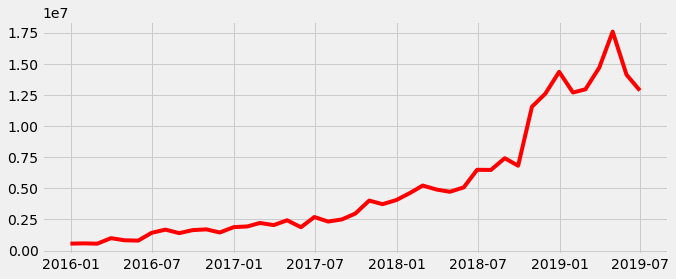

In [1521]:
plt.figure(figsize=(10,4))
plt.plot(ts, color="red")
plt.grid(True)
plt.show()

*From the above plot it can be inferred clearly that our data is suffering of trend and seasonality both.*

<font color="red"> **B)STATISTICAL METHOD**

*Here we will see the presence of trend and  seasonality by statistical methods. In visual methods we can have only the inspection of presence of trend and seasonality but in stats we measure it in terms of stastical entities.*

**DICKEY FULLER TEST**

> *This test is used to test a hypothesis of whether the timeseries is stationry or not. It gives some statistical measures and some critical values with which our test stats has to be compared.*

In [1522]:
#Here the library containing the dickey fuller test is imported
from statsmodels.tsa.stattools import adfuller

In [1523]:
def dft(ts):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [1524]:
dft(ts)

Results of Dickey-Fuller Test:
Test Statistic                  3.822964
p-value                         1.000000
#Lags Used                      9.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


**Interpretation of the dickey fuller test**  
*If the Test Statistic is lesser than(considering values with sign) the critical values then we can conclude that the series has no trend and seasonality. For example here the Test Statistics is greater than all the critical values then it means that the series is not stationary.*

**REMOVING TREND AND SEASONALITY FROM THE SERIES(MAKING IT STATIONARY)**

*To make the series stationary first a logarithmic transformation has been applied. This reduces the trend a little.*

In [1525]:
ts_log=np.log(ts[ts>0])

In [1526]:
#Calling the Dickey fuller test to test for the transformed data.
dft(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  0.138792
p-value                         0.968612
#Lags Used                      8.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


**It is intrepretable that the Test Statistic has dicreased a bit but still greater than the critical values. Hence it is non stationary yet.**

**DIFFERENCING**

*Following is the differencing technique used to make the series stationary.*

In [1527]:
ts_log_diff=ts_log-ts_log.shift()
#The shift function moves the whole series by one unit. Then the difference has been taken to remove trends.

*In the following plot we can see that trend has been removed from the series.*

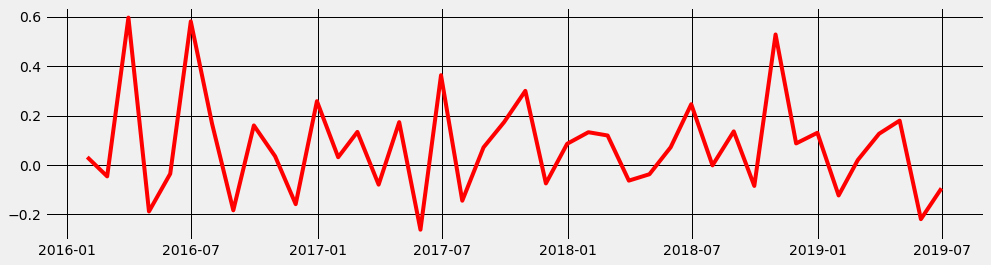

In [1528]:
plt.figure(figsize=(15,4))
plt.plot(ts_log_diff, color="red")
plt.grid(True, color="black")
plt.show()

In [1529]:
ts_log_diff.dropna(inplace=True)
# This comes because when difference was taken the value was shifed by
# one unit and value corresponding to that index is no more. so it is 
# needed to drop that one na value.

**Now let us see the stationary test after application of differencing in the series**

In [1530]:
dft(ts_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -5.050791
p-value                         0.000018
#Lags Used                      2.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64


**Test Statistic is less than 1 percent critical value. So with 99% confidence we can say that trend and seasonality are removed from this timeseries.**

**MODEL PREPARATION**

In [1531]:
from statsmodels.tsa.stattools import acf, pacf
# Requisite libraries for computing auto correlation function and partial auto correlation function. 

In [1532]:
lag_acf = acf(ts_log_diff, nlags=5)
lag_pacf = pacf(ts_log_diff, nlags=5, method='ols')
#ols stands for ordinary least squared.

**PURPOSE OF ACF AND PACF PLOTTINGS**  
*These are two kinds of plots that are used to compute the lag order of auto correlation data and partial auto correlation data. These orders are used as input to the arima model for model preparation.*

Text(0.5, 1.0, 'Autocorrelation Function')

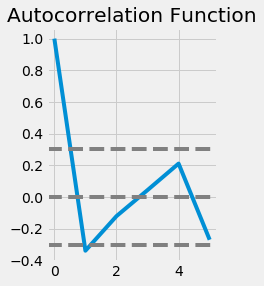

In [1533]:
#This is the plotting of acf.
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

*The p value is the lag value at which the correlation plot is intersecting the upper confidence intervel. If we will drop that point to x axis it is around 1 if taken as integer. so p value is 1*

*This is done to get the lag order of moving average. or it is called to be partial auto correlation function.*

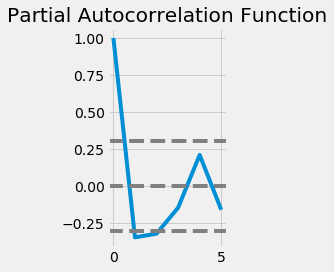

In [1534]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

*From the plot it can be interpreted that q value is also around 1. The way of interpretation is similar to the last one.*

**RUNNING THE SARIMAX(THIS IS SEASONAL ARIMA) MODEL**

In [1535]:
mod = sm.tsa.statespace.SARIMAX(ts_log_diff,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1,2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

*The model is fit to the differenced data*

*Following code is to forecast the amount for coming 6 months.*

In [1536]:
pred_uc=results.get_forecast(steps=7)
pred_ci = pred_uc.conf_int()

*The output is consisting of lower amount and upper amount. These are kind of minimum and maximum forecast for a month. I have taken average of the two extremes to make the forecast more practical.*

In [1537]:
pred_ci

,lower Amount,upper Amount
2019-07-31,-0.328738,0.320168
2019-08-31,-0.224565,0.424185
2019-09-30,-0.440677,0.214420
2019-10-31,-0.326506,0.328567
2019-11-30,-0.448405,0.294136
2019-12-31,-0.338659,0.403752
2020-01-31,-0.496319,0.285146


In [1538]:
pred_mean=(pred_ci.iloc[:,0]+pred_ci.iloc[:,1])/2

**REVERSING ALL THE TRANSFORMATIONS IN THE SERIES**  
This is needed to get the output into the original format of data.

In [1539]:
predictions_ARIMA_diff = pd.Series(pred_mean, copy=True)

*Cumulative summation reverses the process of differencing*

In [1540]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [1541]:
a=ts_log[-1]

*After that we need to add that to the last reference value of the series. This is the base value. We can have the original value after adding it to the base value.*

In [1542]:
b=a+predictions_ARIMA_diff_cumsum

*As we have applied logrithmic transformation initially so we need to get exponent of the same so that we can have the data into original scale.*

In [1543]:
predictions_ARIMA = np.exp(b)

In [1544]:
type(predictions_ARIMA)

pandas.core.series.Series

In [1545]:
predictions_ARIMA

2019-07-31    1.280881e+07
2019-08-31    1.415323e+07
2019-09-30    1.263934e+07
2019-10-31    1.265238e+07
2019-11-30    1.171313e+07
2019-12-31    1.210062e+07
2020-01-31    1.088810e+07
Freq: M, dtype: float64

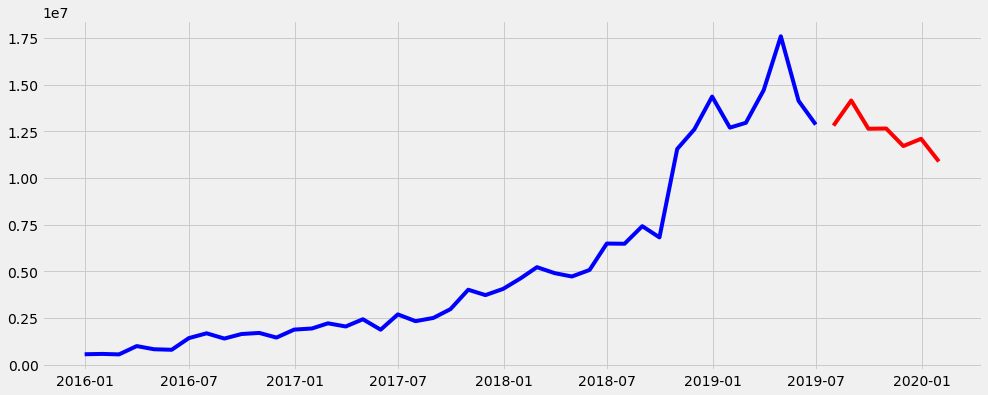

In [1546]:
plt.figure(figsize=(15,6))
plt.plot(ts, color="blue")
plt.plot(predictions_ARIMA,color="red")
plt.grid(True)
plt.show()

**This is the final output which is consisting of forecast of amount for seller 13 for coming 6 months.**

In [1553]:
forecast=pd.DataFrame()
forecast["amount"]=predictions_ARIMA
forecast["amount"]=forecast.amount.apply(lambda x:format(x,".1f"))
forecast

,amount
2019-07-31,12808807.1
2019-08-31,14153230.8
2019-09-30,12639343.3
2019-10-31,12652377.7
2019-11-30,11713128.4
2019-12-31,12100620.5
2020-01-31,10888098.5
